In [1]:
import ast_preprocess_dataloader
from ast_preprocess_dataloader import AudioPipeline
import torchaudio
import torch
import os
import glob
from torch.utils.data import Dataset, DataLoader
from audiomentations import Compose, TimeStretch, PitchShift, HighPassFilter, LowPassFilter, BandPassFilter
import numpy as np
from transformers import AutoProcessor
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is using GPU 🟢")
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU 🟡")

PyTorch is using GPU 🟢


## **오디오 경로 불러오기**

In [3]:
dir_path = r'c:/Users/Desk_Kang/Desktop/Aiffel/workplace/lib/Aiffelthon/orig_resample'
dir_path
os.path.exists(dir_path)

True

In [4]:
class_name = os.listdir(dir_path)
class_name

['bellypain', 'discomfort', 'hungry', 'tired']

In [5]:
audio_dir = [os.path.join(dir_path, name) for name in class_name]
audio_dir

['c:/Users/Desk_Kang/Desktop/Aiffel/workplace/lib/Aiffelthon/orig_resample\\bellypain',
 'c:/Users/Desk_Kang/Desktop/Aiffel/workplace/lib/Aiffelthon/orig_resample\\discomfort',
 'c:/Users/Desk_Kang/Desktop/Aiffel/workplace/lib/Aiffelthon/orig_resample\\hungry',
 'c:/Users/Desk_Kang/Desktop/Aiffel/workplace/lib/Aiffelthon/orig_resample\\tired']

In [6]:
bpain_audio = glob.glob(os.path.join(audio_dir[0], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_dir[1], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_dir[2], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_dir[3], '*.wav'))

In [7]:
audio_path_class = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

In [8]:
all_paths = []
all_labels = []

for (label, class_name), path_lst in zip(enumerate(audio_path_class), audio_path_class.values()):
    for path in path_lst:
        all_paths.append(path)
        all_labels.append(label)

## **훈련, 검증, 테스트 경로 쪼개기**

In [9]:
train_paths, val_paths, train_labels, val_labels = train_test_split(all_paths, all_labels, test_size=0.4, random_state=42)

In [10]:
# 갯수 확인
print(len(train_paths))
print(len(val_paths))
print(len(train_labels))
print(len(val_labels))

117
78
117
78


In [11]:
val_paths, test_paths, val_labels, test_labels = train_test_split(val_paths, val_labels, test_size=0.5, random_state=42)

In [12]:
# 갯수 확인
print(len(val_paths))
print(len(test_paths))
print(len(val_labels))
print(len(test_labels))

39
39
39
39


## **파이프라인 만들기**

In [13]:
augmentations = Compose([
    BandPassFilter(min_center_freq=1500, max_center_freq=1500,
                   max_bandwidth_fraction=0.8, min_bandwidth_fraction=0.8,
                   max_rolloff=12, min_rolloff=12, p=1.0)
])

train_dataset = AudioPipeline(audio_paths=train_paths, audio_labels=train_labels, sr=20000, transform=augmentations)
val_dataset = AudioPipeline(audio_paths=val_paths, audio_labels=val_labels, sr=20000)
test_dataset = AudioPipeline(audio_paths=val_paths, audio_labels=val_labels, sr=20000)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

## **훈련, 검증, 테스트 batch 불러오기**

In [15]:
# 훈련 데이터 배치 불러오기
for batch in train_dataloader:
    input_values, labels = batch
    print(input_values.shape, labels.shape)

torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([7, 1024, 128]) torch.Size([7])


In [16]:
# 검증 데이터 배치 불러오기
for batch in val_dataloader:
    input_values, labels = batch
    print(input_values.shape, labels.shape)

torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([9, 1024, 128]) torch.Size([9])


In [17]:
# 테스트 데이터 배치 불러오기
for batch in test_dataloader:
    input_values, labels = batch
    print(input_values.shape, labels.shape)

torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([10, 1024, 128]) torch.Size([10])
torch.Size([9, 1024, 128]) torch.Size([9])


## 모델 불러오기

In [18]:
import torch.nn.functional as F
import torch.nn as nn
from transformers import ASTConfig, ASTModel, ASTFeatureExtractor

class CustomASTClassifier(nn.Module):
    def __init__(self, ast_model_name, num_labels):
        super().__init__()
        self.astconfig = ASTConfig() # 괄호 안에 configuration 값 넣어주면 됩니다. 아마 sampling rate도 20000으로 맞춰주시면 될 것 같아요.
        self.ast = ASTModel.from_pretrained(ast_model_name) # 요거 안되면 질문주세요 self.astconfig
        self.num_labels = num_labels
        for param in self.ast.parameters():
            param.requires_grad = False

        # 요 아래코드에 Convolution 과 classifier 설정해주시면 됩니다..

        # 예시
        
        self.conv1d1 = nn.Sequential(
            nn.Conv1d(in_channels=768,
                      out_channels = 384,
                      kernel_size = 1,
                      stride = 1),
            nn.BatchNorm1d(384),
            nn.ReLU())
        
        self.conv1d2 = nn.Sequential(
            nn.Conv1d(in_channels=384,
                      out_channels = 192,
                      kernel_size = 1,
                      stride = 1),
            nn.BatchNorm1d(192),
            nn.ReLU())
        
        self.conv1d3 = nn.Sequential(
            nn.Conv1d(in_channels=192,
                      out_channels = 90,
                      kernel_size = 1,
                      stride = 1),
            nn.BatchNorm1d(90),
            nn.ReLU())
        
        # self.conv1d4 = nn.Sequential(
        #     nn.Conv1d(in_channels=128,
        #               out_channels = 64,
        #               kernel_size = 1,
        #               stride = 1),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU())        

        # self.conv1d5 = nn.Sequential(
        #     nn.Conv1d(in_channels=64,
        #               out_channels = 32,
        #               kernel_size = 1,
        #               stride = 1),
        #     nn.BatchNorm1d(32),
        #     nn.ReLU())

        # self.conv1d6 = nn.Sequential(
        #     nn.Conv1d(in_channels=32,
        #               out_channels = 16,
        #               kernel_size = 1,
        #               stride = 1),
        #     nn.BatchNorm1d(16),
        #     nn.ReLU())

        self.adapted = nn.AdaptiveAvgPool1d(1)

        # self.classifier = nn.Linear(1214, 512)
        self.layer_fc1 = nn.Sequential(
            nn.Linear(90,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3))
        
        self.layer_fc2 = nn.Sequential(
            nn.Linear(32,16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3))
        
        self.layer_fc3 = nn.Sequential(
            nn.Linear(16,8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.3))
        
        
        self.add_layer_01 = nn.Linear(8, num_labels)
        self.num_labels = num_labels
        

    def forward(self, input_values, labels=None):
        input_values = input_values.float()
        outputs = self.ast(input_values)
        embeddings = outputs.last_hidden_state


        embeddings_t = embeddings.transpose(1,2)
        # 요 아래 부분부터 Feed Forward 부분이니 위에서 설정한 Convolution과 classifier를 넣어주시면 됩니다.
        # 예시)
        
        # embeddings = embeddings.unsqueeze(1)
        
        # Convolution block
        conv_output1 = self.conv1d1(embeddings_t)
        conv_output2 = self.conv1d2(conv_output1)
        conv_output3 = self.conv1d3(conv_output2)

        adap_out = self.adapted(conv_output3)

        output_sq = torch.squeeze(adap_out, dim=1)

        flattened_output = adap_out.view(output_sq.size(0), -1)

        logits = self.layer_fc1(flattened_output)
        logits = self.layer_fc2(logits)
        logits = self.layer_fc3(logits)
        logits = torch.relu(logits)
        logits = self.add_layer_01(logits)
        

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1).long())
            return loss, logits
        return logits

In [19]:
import torch.optim as optim
import matplotlib.pyplot as plt

num_labels = 4
ast_model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
model = CustomASTClassifier(ast_model_name, num_labels).to(device)


# Initialize metric lists
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

In [20]:
ast_loss_fn = torch.nn.CrossEntropyLoss()

In [27]:
def find_learning_rate(model, train_loader, loss_fn, device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    lr_find_loss = []
    lr_find_lr = []

    lr_init = 1e-5# <<<< 요기만 바꾸면됨
    lr_final = 1e-3
    n_steps = 100
    current_lr = lr_init
    lr_increment = (lr_final / lr_init) ** (1/n_steps)

    model.train()  # Set model to training mode

    for batch_idx, batch in enumerate(train_loader):
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.param_groups[0]['lr'] = current_lr
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lr_find_loss.append(loss.item())
        lr_find_lr.append(current_lr)

        current_lr *= lr_increment
        if current_lr > lr_final:
            break

    plt.plot(lr_find_lr, lr_find_loss)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.show()
    return lr_find_lr, lr_find_loss

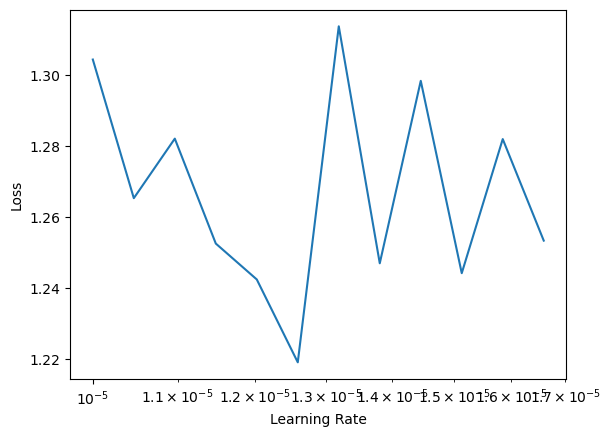

([1e-05,
  1.0471285480508997e-05,
  1.0964781961431854e-05,
  1.1481536214968832e-05,
  1.2022644346174135e-05,
  1.258925411794168e-05,
  1.318256738556408e-05,
  1.3803842646028859e-05,
  1.4454397707459287e-05,
  1.5135612484362095e-05,
  1.584893192461115e-05,
  1.6595869074375625e-05],
 [1.304281234741211,
  1.2652660608291626,
  1.2820208072662354,
  1.25249445438385,
  1.2423897981643677,
  1.2190699577331543,
  1.3136277198791504,
  1.2469382286071777,
  1.298281192779541,
  1.2441580295562744,
  1.2818948030471802,
  1.2533206939697266])

In [28]:
find_learning_rate(model, train_dataloader, ast_loss_fn, device=device)

In [23]:
# Define your optimizer, loss function, etc.
optimizer = optim.Adam(model.parameters(), lr=1.31e-04)  #1.23e-05, 2.754e-06

## **훈련, 검증 에폭적용시**

**아래와 같이 맞춰주시면 됩니다.**

```python

```

In [24]:
from tqdm import tqdm

# 검증 데이터 배치 불러오기
for epoch in range(125):
    total_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    # Training phase
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_values, labels = batch
        input_values, labels = input_values.to(device), labels.to(device)

        loss, logits = model(input_values, labels)
        total_loss += loss.item()

        # Calculate accuracy
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    train_accuracy = correct / total
    train_losses.append(total_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    if val_dataloader is not None:
        model.eval()
        with torch.no_grad():
            val_loss, correct, total = 0, 0, 0
            for batch in val_dataloader:
                input_values, labels = batch
                input_values, labels = input_values.to(device), labels.to(device)

                loss, logits = model(input_values, labels)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            val_accuracy = correct / total
            val_losses.append(val_loss / len(val_dataloader))
            val_accuracies.append(val_accuracy)

        model.train()

Epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 125:   0%|          | 0/12 [00:11<?, ?it/s, loss=1.33]

## **테스트 적용시**

```python

```

In [25]:
model.eval()  

correct = 0
total = 0
with torch.no_grad():  
    for data in test_dataloader:  
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 51.28%


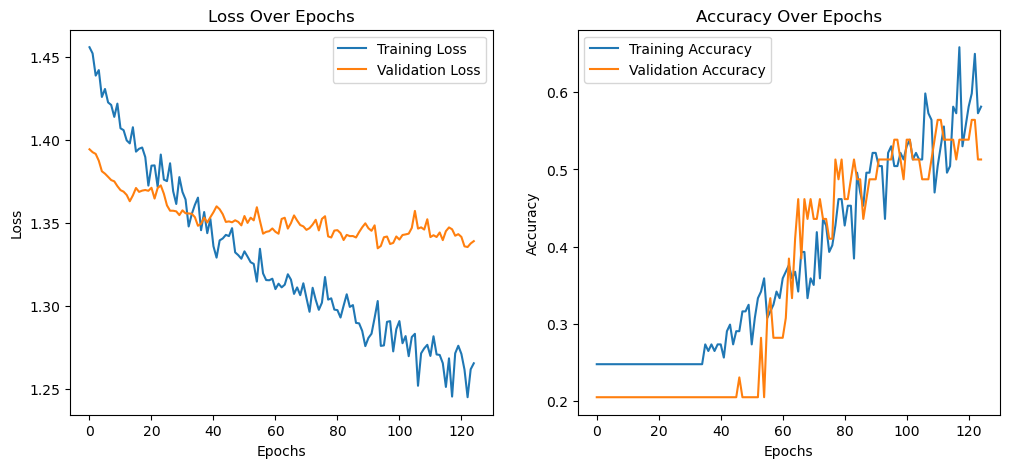

In [26]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
if val_dataloader is not None:
    plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
if val_dataloader is not None:
    plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig("win500_set2.2_test_epc200_flattened.png") # 그래프 사진은 주석풀어서 사진이름만 설정해주시면 됩니다.

plt.show()